In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
def plot_img(img, gray=False):
    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(111)
    if gray == False:
        img = img[:, :, :: -1]
        ax.imshow(img)
    else:
        ax.imshow(img, cmap='gray')

    plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
def normalize_kernel(kernel, k_width, k_height, scaling_factor = 1.0):
    '''Zero-summing normalize kernel'''
    
    K_EPS = 1.0e-12
    # positive and negative sum of kernel values
    pos_range, neg_range = 0, 0
    for i in range(k_width * k_height):
        if abs(kernel[i]) < K_EPS:
            kernel[i] = 0.0
        if kernel[i] < 0:
            neg_range += kernel[i]
        else:
            pos_range += kernel[i]
    
    # scaling factor for positive and negative range
    pos_scale, neg_scale = pos_range, -neg_range
    if abs(pos_range) >= K_EPS:
        pos_scale = pos_range
    else:
        pos_sacle = 1.0
    if abs(neg_range) >= K_EPS:
        neg_scale = 1.0
    else:
        neg_scale = -neg_range
        
    pos_scale = scaling_factor / pos_scale
    neg_scale = scaling_factor / neg_scale
    
    # scale kernel values for zero-summing kernel
    for i in range(k_width * k_height):
        if (not np.nan == kernel[i]):
            kernel[i] *= pos_scale if kernel[i] >= 0 else neg_scale
            
    return kernel

def dog(img, k_size, sigma_1, sigma_2):
    '''Difference of Gaussian by subtracting kernel 1 and kernel 2'''
    
    k_width = k_height = k_size
    x = y = (k_width - 1) // 2
    kernel = np.zeros(k_width * k_height)
    
    # first gaussian kernal
    if sigma_1 > 0:
        co_1 = 1 / (2 * sigma_1 * sigma_1)
        co_2 = 1 / (2 * np.pi * sigma_1 * sigma_1)
        i = 0
        for v in range(-y, y + 1):
            for u in range(-x, x + 1):
                kernel[i] = np.exp(-(u*u + v*v) * co_1) * co_2
                i += 1
    # unity kernel
    else:
        kernel[x + y * k_width] = 1.0
    
    # subtract second gaussian from kernel
    if sigma_2 > 0:
        co_1 = 1 / (2 * sigma_2 * sigma_2)
        co_2 = 1 / (2 * np.pi * sigma_2 * sigma_2)
        i = 0
        for v in range(-y, y + 1):
            for u in range(-x, x + 1):
                kernel[i] -= np.exp(-(u*u + v*v) * co_1) * co_2
                i += 1
    # unity kernel
    else:
        kernel[x + y * k_width] -= 1.0
    
    # zero-normalize scling kernel with scaling factor 1.0
    norm_kernel = normalize_kernel(kernel, k_width, k_height, scaling_factor = 1.0)
    
    # apply filter with norm_kernel
    return cv2.filter2D(img, -1, norm_kernel.reshape(k_width, k_height))

def negate(img):
    '''Negative of image'''
    return cv2.bitwise_not(img)

def color_balance(img, low_per, high_per):
    '''Contrast stretch image by histogram equilization with black and white cap'''
    
    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100
    
    cs_img = []
    # for each channel, apply contrast-stretch
    for ch in cv2.split(img):
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li 
                        else (255 if i > hi else round((i - li) / (hi - li) * 255)) 
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)
        
    return cv2.merge(cs_img)

def get_black_white_indices(hist, tot_count, black_count, white_count):
    '''Blacking and Whiting out indices same as color balance'''
    black_ind = 0
    white_ind = 255
    co = 0
    for i in range(len(hist)):
        co += hist[i]
        if co > black_count:
            black_ind = i
            break
            
    co = 0
    for i in range(len(hist) - 1, -1, -1):
        co += hist[i]
        if co > (tot_count - white_count):
            white_ind = i
            break
    
    return [black_ind, white_ind]

def contrast_stretch(img, black_point, white_point):
    '''Contrast stretch image with black and white cap'''
    
    tot_count = img.shape[0] * img.shape[1]
    black_count = tot_count * black_point / 100
    white_count= tot_count * white_point / 100
    ch_hists = []
    # calculate histogram for each channel
    for ch in cv2.split(img):
        ch_hists.append(cv2.calcHist([ch], [0], None, [256], (0, 256)).flatten().tolist())
    
    # get black and white percentage indices
    black_white_indices = []
    for hist in ch_hists:
        black_white_indices.append(get_black_white_indices(hist, tot_count, black_count, white_count))
        
    stretch_map = np.zeros((3, 256), dtype = 'uint8')
    
    # stretch histogram 
    for curr_ch in range(len(black_white_indices)):
        black_ind, white_ind = black_white_indices[curr_ch]
        for i in range(stretch_map.shape[1]):
            if i < black_ind:
                stretch_map[curr_ch][i] = 0
            else:
                if i > white_ind:
                    stretch_map[curr_ch][i] = 255
                else:
                    if (white_ind - black_ind) > 0:
                        stretch_map[curr_ch][i] = round((i - black_ind) / (white_ind - black_ind)) * 255
                    else:
                        stretch_map[curr_ch][i] = 0
    
    # stretch image
    ch_stretch = []
    for i, ch in enumerate(cv2.split(img)):
        ch_stretch.append(cv2.LUT(ch, stretch_map[i]))
        
    return cv2.merge(ch_stretch)

def fast_gaussian_blur(img, ksize, sigma):
    '''Gussian blur using linear separable property of Gaussian distribution'''
    
    kernel_1d = cv2.getGaussianKernel(ksize, sigma)
    return cv2.sepFilter2D(img, -1, kernel_1d, kernel_1d)

def gamma(img, gamma_value):
    '''Gamma correction of image'''
    
    i_gamma = 1 / gamma_value
    lut = np.array([((i / 255) ** i_gamma) * 255 for i in np.arange(0, 256)], dtype = 'uint8')
    return cv2.LUT(img, lut)

In [4]:
dog_k_size, dog_sigma_1, dog_sigma_2 = 15, 100, 0
cs_black_per, cs_white_per = 2, 99.5
gauss_k_size, gauss_sigma = 3, 1
gamma_value = 1.1
cb_black_per, cb_white_per = 2, 1

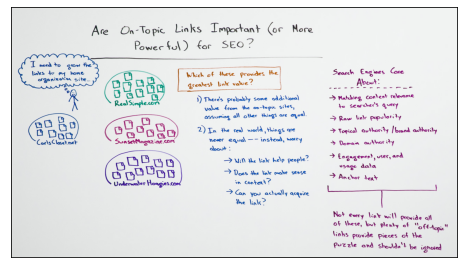

In [5]:
img = cv2.imread('../images/22.jpg')
plot_img(img)

In [6]:
# Difference of Gaussian (DoG)
dog_img = dog(img, dog_k_size, dog_sigma_1, dog_sigma_2)
# Negative of image
negative_img = negate(dog_img)
# Contrast Stretch (CS)
contrast_stretch_img = contrast_stretch(negative_img, cs_black_per, cs_white_per)
# Gaussian Blur
blur_img = fast_gaussian_blur(contrast_stretch_img, gauss_k_size, gauss_sigma)
# Gamma Correction
gamma_img = gamma(blur_img, gamma_value)
# Color Balance (CB) (also Contrast Stretch)
color_balanced_img = color_balance(gamma_img, cb_black_per, cb_white_per)

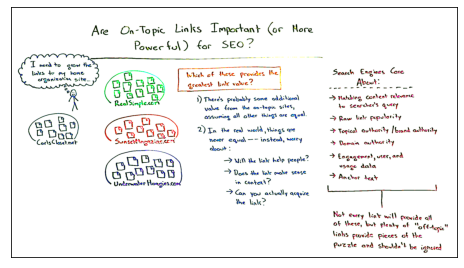

In [7]:
plot_img(color_balanced_img)